# Kaggle Competition: Stack Overflow Closed Discussions

Currently about 6% of all new questions on Stack Overflow end up "closed". Questions can be closed as off-topic, not constructive, not a real question, or too localized. The goal of this project is to build a classifier that predicts whether or not a question will be closed given the question as submitted. Additional data about the user at question creation time is also available.

This private competition was hosted on Kaggle by <a href=http://www.dataschool.io>Data School</a> as part of the Machine Learning with Text in Python eight-week training session.

**The notebook is organized as follow:**
* [1) Reading the data](#1-reading-the-data)
* [2) Feature Engineering](#2-feature-engineering)
* [3) Learning on numerical features only](#3-learning-on-numerical-features-only)
* [4) Learning on text features only](#4-learning-on-text-features-only)
* [5) Learning on both text and numerical features](#5-learning-on-both-text-and-numerical-features)

## 1) Reading the data <a class="anchor" id="1-reading-the-data"></a>

Let's load the data, go through it and prepare it a little.

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('./data/train.csv', index_col=0)

In [3]:
train.head()

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
0,6046168,05/18/2011 14:14:05,543315,09/17/2010 10:15:06,1,2,For Mongodb is it better to reference an objec...,I am building a corpus of indexed sentences in...,mongodb,NaN,NaN,NaN,NaN,NaN,1
1,4873911,02/02/2011 11:30:10,465076,10/03/2010 09:30:58,192,24,How to insert schemalocation in a xml document...,i create a xml document with JAXP and search a...,dom,xsd,jaxp,NaN,NaN,NaN,1
2,3311559,07/22/2010 17:21:54,406143,07/22/2010 16:58:20,1,0,Too many lookup tables,What are the adverse effects of having too man...,sql-server,database-design,enums,NaN,NaN,NaN,1
3,9990413,04/03/2012 09:18:39,851755,07/19/2011 10:22:40,4,1,What is this PHP code in VB.net,I am looking for the vb.net equivalent of this...,php,vb.net,NaN,NaN,NaN,04/15/2012 21:12:48,0
4,10421966,05/02/2012 21:25:01,603588,02/04/2011 18:05:34,334,14,Spring-Data mongodb querying multiple classes ...,"With Spring-Data, you can use the @Document an...",mongodb,spring-data,NaN,NaN,NaN,NaN,1


In [4]:
# Shape of the train set
train.shape

(140272, 15)

In [5]:
# Balance of the train set
train.OpenStatus.value_counts()

1    70136
0    70136
Name: OpenStatus, dtype: int64

The dataset is perfectly balanced. That's going to be convenient.

In [6]:
# Types of the train set
train.dtypes

PostId                                  int64
PostCreationDate                       object
OwnerUserId                             int64
OwnerCreationDate                      object
ReputationAtPostCreation                int64
OwnerUndeletedAnswerCountAtPostTime     int64
Title                                  object
BodyMarkdown                           object
Tag1                                   object
Tag2                                   object
Tag3                                   object
Tag4                                   object
Tag5                                   object
PostClosedDate                         object
OpenStatus                              int64
dtype: object

In [7]:
# Dates columns to datetime format
train.PostCreationDate = pd.to_datetime(train.PostCreationDate)
train.OwnerCreationDate = pd.to_datetime(train.OwnerCreationDate)
# train.PostClosedDate = pd.to_datetime(train.PostClosedDate)  -- will be dropped afterwards

In [8]:
# Missing values
train.isnull().sum()

PostId                                      0
PostCreationDate                            0
OwnerUserId                                 0
OwnerCreationDate                           0
ReputationAtPostCreation                    0
OwnerUndeletedAnswerCountAtPostTime         0
Title                                       0
BodyMarkdown                                0
Tag1                                        2
Tag2                                    27228
Tag3                                    64328
Tag4                                   100609
Tag5                                   124555
PostClosedDate                          70136
OpenStatus                                  0
dtype: int64

PostClosedDate has as many missing values as open posts, which is pretty logical. This column is the only one which we will not use, for two reasons. First, it contains "future information", i.e. information which will not be available on the test set. Then, the only other information it contains is the date of closing, which coes not interest us.

Other that that, only tags contain missing values, which is also going to be convenient.

In [9]:
# Removing PostClosedDate
train = train.drop('PostClosedDate', axis=1)

In [10]:
# Closer look at the timeframes considered
print('Min post creation date: ', train.PostCreationDate.min())
print('Max post creation date: ', train.PostCreationDate.max())
print('Min owner creation date: ', train.OwnerCreationDate.min())
print('Max owner creation date: ', train.OwnerCreationDate.max())

Min post creation date:  2008-08-01 00:42:38
Max post creation date:  2012-07-31 23:44:55
Min owner creation date:  2008-07-31 14:22:31
Max owner creation date:  2012-07-31 23:37:24


## 2. Feature Engineering <a class="anchor" id="2-feature-engineering"></a>

In this step we are trying to create new numeric columns which might be helpful to train our model predict the closure of a post.

In [11]:
%matplotlib inline

### 2.a) Post Creation Date features

In [12]:
# Post Creation time values
train['PostCreationDate_hour'] = train.PostCreationDate.dt.hour
train['PostCreationDate_day'] = train.PostCreationDate.dt.dayofweek
train['PostCreationDate_month'] = train.PostCreationDate.dt.month
train['PostCreationDate_year'] = train.PostCreationDate.dt.year

In [13]:
train.head()

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,OpenStatus,PostCreationDate_hour,PostCreationDate_day,PostCreationDate_month,PostCreationDate_year
0,6046168,2011-05-18 14:14:05,543315,2010-09-17 10:15:06,1,2,For Mongodb is it better to reference an objec...,I am building a corpus of indexed sentences in...,mongodb,NaN,NaN,NaN,NaN,1,14,2,5,2011
1,4873911,2011-02-02 11:30:10,465076,2010-10-03 09:30:58,192,24,How to insert schemalocation in a xml document...,i create a xml document with JAXP and search a...,dom,xsd,jaxp,NaN,NaN,1,11,2,2,2011
2,3311559,2010-07-22 17:21:54,406143,2010-07-22 16:58:20,1,0,Too many lookup tables,What are the adverse effects of having too man...,sql-server,database-design,enums,NaN,NaN,1,17,3,7,2010
3,9990413,2012-04-03 09:18:39,851755,2011-07-19 10:22:40,4,1,What is this PHP code in VB.net,I am looking for the vb.net equivalent of this...,php,vb.net,NaN,NaN,NaN,0,9,1,4,2012
4,10421966,2012-05-02 21:25:01,603588,2011-02-04 18:05:34,334,14,Spring-Data mongodb querying multiple classes ...,"With Spring-Data, you can use the @Document an...",mongodb,spring-data,NaN,NaN,NaN,1,21,2,5,2012


Let us now check one by one these new features and check if some of them seem to be good at predicting OpenStatus. To do so, we look at the mean of OpenStatus, grouping by every of these features. This gives us the probability of a post being Open, per hour/dayofweek/month/year.

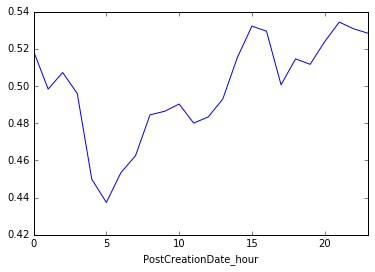

In [14]:
train.groupby('PostCreationDate_hour').OpenStatus.mean().plot()

One can notice that posts created in the night (hour 4 to 7) are less likely to be open.

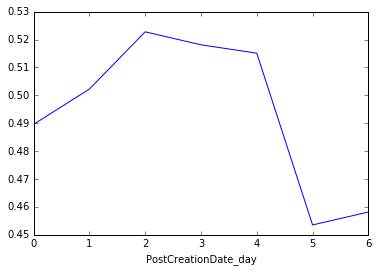

In [15]:
train.groupby('PostCreationDate_day').OpenStatus.mean().plot()

One can notice that posts created during the weekend (days 5 and 6) are less likely to be open.

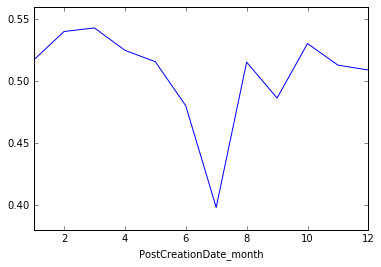

In [16]:
train.groupby('PostCreationDate_month').OpenStatus.mean().plot()

One can notive that posts published in july are the most unlikely to be open.

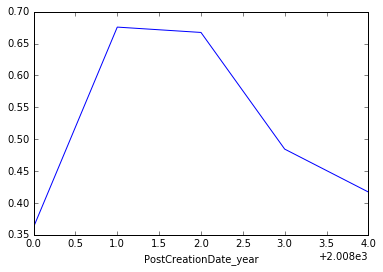

In [17]:
train.groupby('PostCreationDate_year').OpenStatus.mean().plot()

One can notice than oldest (2008) newest posts (at least 2011) are more likely to be closed than the others.

**We can now create or new columns for post creation date, which will help us predict if a post is closed or not.**

In [18]:
train['PostCreationDate_night'] = ((train.PostCreationDate_hour) >= 4 & (train.PostCreationDate_hour <= 7)).astype(int)
train['PostCreationDate_weekend'] = ((train.PostCreationDate_day) >= 5 & (train.PostCreationDate_day <= 6)).astype(int)
train['PostCreationDate_july'] = (train.PostCreationDate_month == 7).astype(int)
train['PostCreationDate_recent'] = ((train.PostCreationDate_year >= 2011) | (train.PostCreationDate_year == 2008)).astype(int)

In [19]:
train.head()

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,...,Tag5,OpenStatus,PostCreationDate_hour,PostCreationDate_day,PostCreationDate_month,PostCreationDate_year,PostCreationDate_night,PostCreationDate_weekend,PostCreationDate_july,PostCreationDate_recent
0,6046168,2011-05-18 14:14:05,543315,2010-09-17 10:15:06,1,2,For Mongodb is it better to reference an objec...,I am building a corpus of indexed sentences in...,mongodb,NaN,...,NaN,1,14,2,5,2011,1,1,0,1
1,4873911,2011-02-02 11:30:10,465076,2010-10-03 09:30:58,192,24,How to insert schemalocation in a xml document...,i create a xml document with JAXP and search a...,dom,xsd,...,NaN,1,11,2,2,2011,1,1,0,1
2,3311559,2010-07-22 17:21:54,406143,2010-07-22 16:58:20,1,0,Too many lookup tables,What are the adverse effects of having too man...,sql-server,database-design,...,NaN,1,17,3,7,2010,1,1,1,0
3,9990413,2012-04-03 09:18:39,851755,2011-07-19 10:22:40,4,1,What is this PHP code in VB.net,I am looking for the vb.net equivalent of this...,php,vb.net,...,NaN,0,9,1,4,2012,1,1,0,1
4,10421966,2012-05-02 21:25:01,603588,2011-02-04 18:05:34,334,14,Spring-Data mongodb querying multiple classes ...,"With Spring-Data, you can use the @Document an...",mongodb,spring-data,...,NaN,1,21,2,5,2012,1,1,0,1


### 2.b) Owner Creation Date features

In [20]:
# Owner Creation time values
train['OwnerCreationDate_hour'] = train.OwnerCreationDate.dt.hour
train['OwnerCreationDate_day'] = train.OwnerCreationDate.dt.dayofweek
train['OwnerCreationDate_month'] = train.OwnerCreationDate.dt.month
train['OwnerCreationDate_year'] = train.OwnerCreationDate.dt.year

In [21]:
train.tail()

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,...,PostCreationDate_month,PostCreationDate_year,PostCreationDate_night,PostCreationDate_weekend,PostCreationDate_july,PostCreationDate_recent,OwnerCreationDate_hour,OwnerCreationDate_day,OwnerCreationDate_month,OwnerCreationDate_year
140267,2982729,2010-06-06 01:03:41,8303,2008-09-15 15:40:08,520,34,Is it possible to implement bitwise operators ...,I am facing a rather peculiar problem. I am wo...,bitwise-operators,discrete-mathematics,...,6,2010,1,1,0,0,15,0,9,2008
140268,8809105,2012-01-10 19:13:53,1130251,2012-01-04 15:31:10,1,0,Ruby on Rails: MySql Gem does not work: uninit...,I have the following installed:\r\nMac Os 10.7...,mysql,ruby-on-rails,...,1,2012,1,1,0,1,15,2,1,2012
140269,10674791,2012-05-20 15:36:31,1388595,2012-05-11 04:43:47,4,0,deleting image from image folder,I am working with an asp.net application.I wan...,asp.net,NaN,...,5,2012,1,1,0,1,4,4,5,2012
140270,3997045,2010-10-22 13:04:30,484232,2010-10-22 13:04:30,1,0,Need help making HTML's,Hi to all the gurus out there.\r\n\r\nAnybody ...,html,copy,...,10,2010,1,1,0,0,13,4,10,2010
140271,11570849,2012-07-19 23:36:57,1539253,2012-07-19 22:17:04,3,1,How dangerous is it to output certain content ...,Following on from a question I asked about esc...,php,content-management-system,...,7,2012,1,1,1,1,22,3,7,2012


Let us now check one by one these new features and check if some of them seem to be good at predicting OpenStatus. We proceed exactly as in the section before.

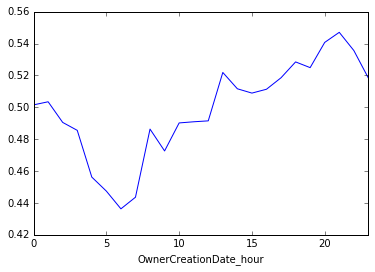

In [22]:
train.groupby('OwnerCreationDate_hour').OpenStatus.mean().plot()

One can notice that posts by owners created in the night (hour 4 to 6) are less likely to be open.

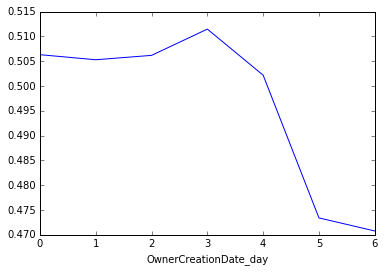

In [23]:
train.groupby('OwnerCreationDate_day').OpenStatus.mean().plot()

One can notice that posts by owners created during the weekend (days 5 and 6) are less likely to be open.

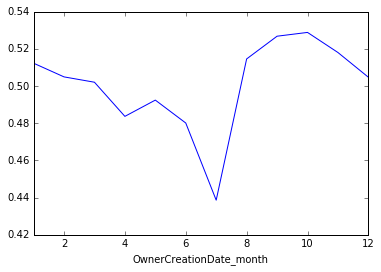

In [24]:
train.groupby('OwnerCreationDate_month').OpenStatus.mean().plot()

One can notive that posts by owners published in july are the most unlikely to be open.

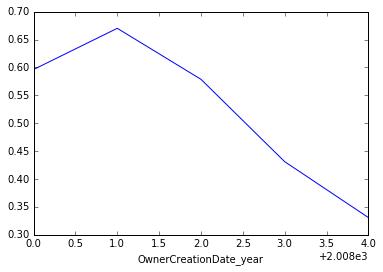

In [25]:
train.groupby('OwnerCreationDate_year').OpenStatus.mean().plot()

One can notice than posts by newest owners (at least 2011) are more likely to be closed than the others.

**We can now create or new columns for owner creation date, which will help us predict if a post is closed or not.**

In [26]:
train['OwnerCreationDate_night'] = ((train.OwnerCreationDate_hour) >= 4 & (train.OwnerCreationDate_hour <= 6)).astype(int)
train['OwnerCreationDate_weekend'] = ((train.OwnerCreationDate_day) >= 5 & (train.OwnerCreationDate_day <= 6)).astype(int)
train['OwnerCreationDate_july'] = (train.OwnerCreationDate_month == 7).astype(int)
train['OwnerCreationDate_recent'] = (train.OwnerCreationDate_year >= 2011).astype(int)

### 2.c) Number of tags

Let's try to figure out if the number of tags can have a correlation with a post's status.

In [27]:
tags = ['Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5']
train['nb_tags'] = 5 - train[tags].isnull().sum(axis=1)

In [28]:
train[tags + ['nb_tags']].tail()

,Tag1,Tag2,Tag3,Tag4,Tag5,nb_tags
140267,bitwise-operators,discrete-mathematics,compiler-optimization,NaN,NaN,3
140268,mysql,ruby-on-rails,gem,osx-lion,NaN,4
140269,asp.net,NaN,NaN,NaN,NaN,1
140270,html,copy,remove,move,NaN,4
140271,php,content-management-system,NaN,NaN,NaN,2


In [29]:
train.groupby('nb_tags').OpenStatus.mean()

nb_tags
0    0.000000
1    0.393403
2    0.484637
3    0.540336
4    0.554836
5    0.544315
Name: OpenStatus, dtype: float64

One can see that the lower the number of tags, the higher the likelyhood of being closed. This feature might thus be useful in the future.

### 2.d) Length of title

Let's try to figure out if the length of a post's title can have a correlation with its status.

In [30]:
train['len_title'] = ((train.Title.str.len())//5)*5
train.groupby('len_title').OpenStatus.mean()

len_title
10     0.354545
15     0.325577
20     0.375259
25     0.416322
30     0.445665
35     0.477927
40     0.501976
45     0.525320
50     0.540217
55     0.554155
60     0.576918
65     0.581654
70     0.573786
75     0.575826
80     0.578540
85     0.571498
90     0.568653
95     0.584983
100    0.548972
105    0.545145
110    0.482838
115    0.513333
120    0.491071
125    0.517857
130    0.461538
135    0.397849
140    0.487805
145    0.403226
150    0.461538
155    1.000000
160    1.000000
165    1.000000
170    0.000000
190    1.000000
200    0.000000
245    1.000000
250    0.000000
Name: OpenStatus, dtype: float64

One can notice that very short titles have a high probability of being closed. Let us set a threshold at 20.

In [31]:
train['short_title'] = (train.Title.str.len() < 25).astype(int)
train.short_title.value_counts()

0    127187
1     13085
Name: short_title, dtype: int64

Around 10% of the posts are among the short-titled posts.

### 2.e) Length of post

In [32]:
import numpy as np

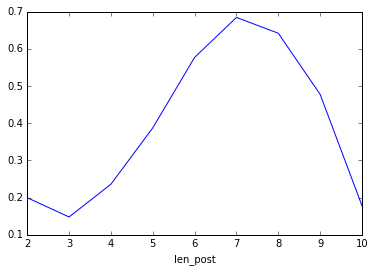

In [33]:
train['len_post'] = train.BodyMarkdown.str.len().apply(np.log).astype(int)
train.groupby('len_post').OpenStatus.mean().plot()

In [34]:
train.len_post.value_counts().sort_index()

2        35
3      1080
4     12034
5     45735
6     55151
7     21348
8      4060
9       672
10      157
Name: len_post, dtype: int64

One can notice that for the lowest and highest values of log(len(post)), the likelihood of being closed is much higher. Lets create a feature for taking this into account.

In [35]:
train['len_post_extreme'] = ((train.BodyMarkdown.str.len().apply(np.log) < 6) | (train.BodyMarkdown.str.len().apply(np.log) > 9)).astype(int)

In [36]:
train[['len_post', 'len_post_extreme']].tail()

,len_post,len_post_extreme
140267,8,0
140268,6,0
140269,5,1
140270,7,0
140271,6,0


### 2.f) Avg length of tags

Let's try to figure out if the average length of tags can have a correlation with the post status.

In [37]:
def get_len_tags(tags):
    if str(tags[0]) == 'nan':
        return 0
    else:
        return (np.mean([len(str(tag)) for tag in tags if str(tag) != 'nan'])//1)

In [38]:
train['len_tags'] = train[tags].apply(get_len_tags, axis=1)

In [39]:
train[tags + ['len_tags']].head()

,Tag1,Tag2,Tag3,Tag4,Tag5,len_tags
0,mongodb,NaN,NaN,NaN,NaN,7.0
1,dom,xsd,jaxp,NaN,NaN,3.0
2,sql-server,database-design,enums,NaN,NaN,10.0
3,php,vb.net,NaN,NaN,NaN,4.0
4,mongodb,spring-data,NaN,NaN,NaN,9.0


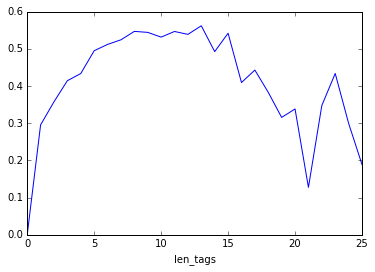

In [40]:
train.groupby('len_tags').OpenStatus.mean().plot()

It does not seem that this feature is very predictive of the status of the post.

### 2.g) Other unusable metrics

Some metrics cannot be used, since they would require some information which we will not have in the future, as we test the model on new data. For example, the number of open or closed posts of the author. This could be computable with the labelled data but not for new unlabelled data. Taking this into account in the training phase of the model would thus make its evaluation too optimistic at best, and could even damage the learning phase.

This is what makes the provided post meta-data such as *OwnerUndeletedAnswerCountAtPostTime* very valuable.

## 3) Learning on numerical features only <a class="anchor" id="3-learning-on-numerical-features-only"></a>

First, let's try to train a model based only on the numerical features (meta-data + engineered numerical features). It will be interesting to see how well it performs, and later on to compare this performance with a model trained on the text data, and even try to combine both.

### 3.a) Preparing train data

In [41]:
import pandas as pd
import numpy as np

# Loading the data
train = pd.read_csv('./data/train.csv', index_col=0)
train.PostCreationDate = pd.to_datetime(train.PostCreationDate)
train.OwnerCreationDate = pd.to_datetime(train.OwnerCreationDate)

In [42]:
train.columns

Index(['PostId', 'PostCreationDate', 'OwnerUserId', 'OwnerCreationDate',
       'ReputationAtPostCreation', 'OwnerUndeletedAnswerCountAtPostTime',
       'Title', 'BodyMarkdown', 'Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5',
       'PostClosedDate', 'OpenStatus'],
      dtype='object')

In [43]:
def create_features(df):
    """ This function takes as input a dataset with the right columns for this problem,
        and adds all the previously-mentioned engineered features to it. It outputs this new
        dataset along with the list of all new features which were added.
    """
    
    new_features = []
    
    # dates columns to datetime format
    df.PostCreationDate = pd.to_datetime(train.PostCreationDate)
    df.OwnerCreationDate = pd.to_datetime(train.OwnerCreationDate)
    
    # post dates features
    df['PostCreationDate_night'] = ((df.PostCreationDate.dt.hour) >= 4 & (df.PostCreationDate.dt.hour <= 7)).astype(int)
    df['PostCreationDate_weekend'] = ((df.PostCreationDate.dt.dayofweek) >= 5 & (df.PostCreationDate.dt.dayofweek <= 6)).astype(int)
    df['PostCreationDate_july'] = (df.PostCreationDate.dt.month == 7).astype(int)
    new_features += ['PostCreationDate_night', 'PostCreationDate_weekend', 'PostCreationDate_july']
    
    # owner dates features
    df['OwnerCreationDate_night'] = ((df.OwnerCreationDate.dt.hour) >= 4 & (df.OwnerCreationDate.dt.hour <= 6)).astype(int)
    df['OwnerCreationDate_weekend'] = ((df.OwnerCreationDate.dt.dayofweek) >= 5 & (df.OwnerCreationDate.dt.dayofweek <= 6)).astype(int)
    df['OwnerCreationDate_july'] = (df.OwnerCreationDate.dt.month == 7).astype(int)
    #df['OwnerCreationDate_recent'] = (df.OwnerCreationDate.dt.year >= 2011).astype(int)
    new_features += ['OwnerCreationDate_night', 'OwnerCreationDate_weekend', 'OwnerCreationDate_july']
    
    # number of tags
    tags = ['Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5']
    df['nb_tags'] = 5 - df[tags].isnull().sum(axis=1)
    new_features += ['nb_tags']
    
    # length of title
    df['short_title'] = (df.Title.str.len() < 25).astype(int)
    new_features += ['short_title']
    
    # length of post
    df['len_post_extreme'] = ((df.BodyMarkdown.str.len().apply(np.log) < 6) | (df.BodyMarkdown.str.len().apply(np.log) > 9)).astype(int)
    new_features += ['len_post_extreme']
    
    return df, new_features

Please note that the feature *PostCreationDate_recent* has been removed, since it turned out to be counter-productive regarding the prediction.

In [44]:
# Create the training set (original dataset + engineered features) and the list of the engineered features
train, new_features = create_features(train)

# Create a list of all numerical features, in order to call them easily later on
numerical_features = ['ReputationAtPostCreation', 'OwnerUndeletedAnswerCountAtPostTime'] + new_features

In [45]:
numerical_features

['ReputationAtPostCreation',
 'OwnerUndeletedAnswerCountAtPostTime',
 'PostCreationDate_night',
 'PostCreationDate_weekend',
 'PostCreationDate_july',
 'OwnerCreationDate_night',
 'OwnerCreationDate_weekend',
 'OwnerCreationDate_july',
 'nb_tags',
 'short_title',
 'len_post_extreme']

In [46]:
# Create the actual learning sets (X matrix and target vector y)
X_num = train[numerical_features]
y_num = train.OpenStatus

In [47]:
# Let's check X out
X_num.head(10)

,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,PostCreationDate_night,PostCreationDate_weekend,PostCreationDate_july,OwnerCreationDate_night,OwnerCreationDate_weekend,OwnerCreationDate_july,nb_tags,short_title,len_post_extreme
0,1,2,1,1,0,1,1,0,1,0,0
1,192,24,1,1,0,1,1,0,3,0,0
2,1,0,1,1,1,1,1,1,3,1,1
3,4,1,1,1,0,1,1,1,2,0,0
4,334,14,1,1,0,1,1,0,2,0,0
5,20,0,1,1,0,1,1,0,2,0,0
6,95,10,1,0,0,1,1,0,4,0,0
7,32,0,1,1,0,1,1,0,4,1,1
8,1,0,1,1,0,1,1,0,1,0,1
9,1,0,1,1,0,1,1,0,1,0,0


### 3.b) Choosing a model

The first step is to choose a model, before tuning it. Let's loop over some of them and see how each of them seem to perform on our data.

In [48]:
from sklearn import metrics
from sklearn.pipeline import make_pipeline

import scipy as sp
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import cross_val_score

from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [49]:
Models = [LogReg, KNN, LinearSVC, LDA]

In [50]:
# For MNB:
# X['ReputationAtPostCreation'] = X.ReputationAtPostCreation + np.absolute(np.min(X.ReputationAtPostCreation, axis=0))
# Result: 0.558094286125

In [51]:
import warnings
from datetime import datetime

In [52]:
warnings.filterwarnings('ignore')

for Model in Models:
    start = datetime.now()
    model = Model()
    scores = cross_val_score(model, X_num, y_num, scoring='accuracy', cv=5)
    end = datetime.now()
    delta = end-start
    print('Accuracy: {0} - Computation time: {1} seconds.'.format(np.mean(scores), delta.seconds))
    
warnings.filterwarnings('default')

Accuracy: 0.6308814628938053 - Computation time: 3 seconds.
Accuracy: 0.5789824052919733 - Computation time: 48 seconds.
Accuracy: 0.602956728488658 - Computation time: 127 seconds.
Accuracy: 0.6306533283838174 - Computation time: 1 seconds.


One can notice that very good results are reached, even without using vectorizers and without using the text data. This is very promising for the future. Let us choose Logistic Regression, which seems to provide the best results.

### 3.c) Tuning the model

To tune the model, I decided to use RandomizedSearchCV, which tries random combinations of the various parameters and provides the scores of each of them. Please not that the scoring method used is log loss, to comply with how the model's prediction will be assessed when submitted (i.e. using log loss).

For the parameter C of the logistic regression, a Rayleigh distribution was chosen in order to try out different values for C, but priviledging those close to 1, known to be often more efficient.

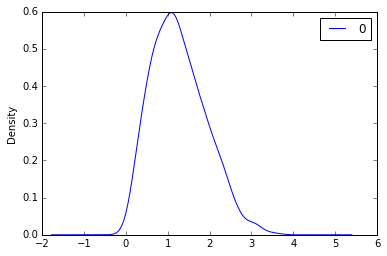

In [53]:
# Checking the distribution chosen
warnings.filterwarnings('ignore')

%matplotlib inline
rayl_data = sp.stats.rayleigh.rvs(size=1000)
pd.DataFrame(rayl_data).plot(kind='density')

warnings.filterwarnings('default')

In [54]:
# Let's instantiate our RandomizedSearchCV
logreg_num = LogReg()
param_grid_num = {'penalty':['l1', 'l2'], 'C':sp.stats.rayleigh()}
rand_num = RandomizedSearchCV(logreg_num, param_grid_num, n_iter=10, scoring='log_loss', cv=5)

In [55]:
# Let's fit our RandomizedSearchCV
%time rand_num.fit(X_num,y_num)

CPU times: user 41.7 s, sys: 1.47 s, total: 43.1 s
Wall time: 28.9 s


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1203d11d0>, 'penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='log_loss', verbose=0)

In [56]:
# Let's print the best score
print(rand_num.best_score_, ' — ', rand_num.best_params_)

-0.65110319291  —  {'C': 1.4484463678220159, 'penalty': 'l1'}


### 3.d) Predicting on test data

In [57]:
# Let's load the test data
test = pd.read_csv('./data/test.csv')
test.PostCreationDate = pd.to_datetime(test.PostCreationDate)
test.OwnerCreationDate = pd.to_datetime(test.OwnerCreationDate)

In [58]:
test.head()

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5
0,11768878,2012-08-01 23:10:12,756422,2011-05-16 21:49:59,155,11,Maven & yui-compressor Plugin issues,I'm using the yui-compressor plugin for maven ...,maven,maven-3,yui-compressor,NaN,NaN
1,11768880,2012-08-01 23:10:21,1569892,2012-08-01 22:24:37,1,0,Inconsistent behaviour of html select dropdowns,I have written a javascript-generated web page...,html,select,drop-down-menu,scrollbar,NaN
2,11803678,2012-08-03 21:40:49,1301879,2012-03-29 21:01:29,781,37,Why Does MSFT C# Compiler Compile fixed Statem...,The .NET c# compiler (.NET 4.0) compiles the `...,c#,.net,compiler,il,NaN
3,11803496,2012-08-03 21:24:02,1196150,2012-02-08 02:20:44,538,0,Dump sql file to ClearDB in Heroku,I have a sql file that I want to be dumped int...,mysql,ruby-on-rails,heroku,NaN,NaN
4,11803700,2012-08-03 21:43:13,772581,2009-11-13 16:24:05,70,2,mysql query to get rows with conditions,"\r\nI have a table called ""articles"" on the da...",mysql,query,NaN,NaN,NaN


In [59]:
# Let's add the new features
test, new_features = create_features(test)

In [60]:
# Create the X matrix
X_test_num = test[numerical_features]
X_test_num.head(20)

,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,PostCreationDate_night,PostCreationDate_weekend,PostCreationDate_july,OwnerCreationDate_night,OwnerCreationDate_weekend,OwnerCreationDate_july,nb_tags,short_title,len_post_extreme
0,155,11,1,1,0,1,1,0,3,0,0
1,1,0,1,1,0,1,1,0,4,0,0
2,781,37,1,1,1,1,1,1,4,0,1
3,538,0,1,1,0,1,1,1,3,0,0
4,70,2,1,1,0,1,1,0,2,0,0
5,176,0,1,1,0,1,1,0,1,1,1
6,2657,161,1,0,0,1,1,0,3,0,0
7,11,0,1,1,0,1,1,0,3,0,0
8,202,4,1,1,0,1,1,0,2,0,1
9,70,5,1,1,0,1,1,0,5,0,0


(Please note that RandomizedSearchCV automatically fits the best model to the whole dataset: one can use it directly afterwards)

In [61]:
# Let's predict the class of the test data, with the model trained earlier.
y_pred_num = rand_num.predict_proba(X_test_num)[:,1]

In [62]:
# Let's create a dataframe with the output
output = pd.DataFrame({'id':X_test_num.index, 'OpenStatus':y_pred_num})

In [63]:
# Let's store the predictions into a submission.csv file
output[['id','OpenStatus']].to_csv('./out/submission.csv', index=False)

The best score obtained with such submissions (only numerical engineered features) was a log loss of 0.61224 for the public score and of 0.61210 for the private score.

## 4) Learning on text features only <a class="anchor" id="4-learning-on-text-features-only"></a>

Now, let's try to train a model based only on the text data, contained in the features *Title*, *BodyMarkdown* and the tags. The process will be to concatenate all this data, to vectorize it and to train a model on the resulting numerical data.

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

In [65]:
train.columns

Index(['PostId', 'PostCreationDate', 'OwnerUserId', 'OwnerCreationDate',
       'ReputationAtPostCreation', 'OwnerUndeletedAnswerCountAtPostTime',
       'Title', 'BodyMarkdown', 'Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5',
       'PostClosedDate', 'OpenStatus', 'PostCreationDate_night',
       'PostCreationDate_weekend', 'PostCreationDate_july',
       'OwnerCreationDate_night', 'OwnerCreationDate_weekend',
       'OwnerCreationDate_july', 'nb_tags', 'short_title', 'len_post_extreme'],
      dtype='object')

In [66]:
# Let's create a function which will concatenate the strings of the considered features, for a given dataset
def create_text_feature(df):
    
    df['Text'] = df.Title.str.cat(df.BodyMarkdown, sep=' ')
    df.Text = df.Text.str.cat(df.Tag1, sep=' ', na_rep='')
    df.Text = df.Text.str.cat(df.Tag2, sep=' ', na_rep='')
    df.Text = df.Text.str.cat(df.Tag3, sep=' ', na_rep='')
    df.Text = df.Text.str.cat(df.Tag4, sep=' ', na_rep='')
    df.Text = df.Text.str.cat(df.Tag5, sep=' ', na_rep='')

    # Let's add the title another time (it was found to enhance prediction accuracy)
    df.Text = df.Text.str.cat(df.Title, sep=' ', na_rep='')
    
    # Return the dataframe with a newly added column: Text
    return df

In [67]:
# Apply this new function to the train data
train = create_text_feature(train)

In [68]:
# Check out the resulting Text feature
train.Text[1]

'How to insert schemalocation in a xml document via DOM i create a xml document with JAXP and search a way to insert the schemalocation.\r\nAt the moment my application produces:\r\n\r\n    <?xml version="1.0" encoding="UTF-8"?>\r\n    <root>\r\n    ...\r\n    </root>\r\n\r\nBut i need:\r\n\r\n    <?xml version="1.0" encoding="UTF-8"?>\r\n    <root xmlns="namespaceURL" \r\n    xmlns:xs="http://www.w3.org/2001/XMLSchema-instance"\r\n    xs:schemaLocation="namespaceURL pathToMySchema.xsd">\r\n    ...\r\n    </root>\r\n\r\nMy code:\r\n\r\n    StreamResult result = new StreamResult(writer);\r\n    Document doc = getDocument();\r\n\r\n    Transformer trans = transfac.newTransformer();\r\n    trans.setOutputProperty(OutputKeys.INDENT, "yes");\r\n    trans.setOutputProperty(OutputKeys.METHOD, "xml");\r\n    trans.setOutputProperty(OutputKeys.VERSION, "1.0");\r\n    trans.setOutputProperty(OutputKeys.ENCODING, "UTF-8");\r\n\r\n    DOMSource source = new DOMSource(depl.getAsElement(doc));\r\n  

In [69]:
X_txt = train.Text
y_txt = train.OpenStatus

There is a specificity here, which could use to be explained. We cannot vectorize the data before splitting between test and train (because this would mean that text data from the testing set has be used in the learning phase).

In order to use cross-validation properly, one need to split between train and set and then only vectorize on the train data only, and repeat this for every train/test combination.

This can be done using pipelines, as follow:

In [70]:
vect_txt = CountVectorizer()
logreg_txt = LogReg()

# Creation of the pipeline
pipe_txt = make_pipeline(vect_txt, logreg_txt)

In [71]:
# Instantiate the RandomizedSearchCV (using the pipeline as model)
rand_param_txt = {'countvectorizer__min_df':[1,2,3],
                  'countvectorizer__stop_words':[None,'english'],
                  'countvectorizer__max_df':sp.stats.uniform(loc=0.1,scale=0.8),
                  'logisticregression__penalty':['l1','l2'],
                  'logisticregression__C':sp.stats.rayleigh()}
rand_txt = RandomizedSearchCV(pipe_txt, rand_param_txt, n_iter=10, cv=5, scoring='log_loss')

In [72]:
# Fit the RandomizedSearchCV
%time rand_txt.fit(X_txt,y_txt)

CPU times: user 54min 19s, sys: 1min 7s, total: 55min 26s
Wall time: 40min 17s


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x146070550>, 'countvectorizer__min_df': [1, 2, 3], 'countvectorizer__stop_words': [None, 'english'], 'countvectorizer__max_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x134a83fd0>, 'logisticregression__penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='log_loss', verbose=0)

In [73]:
# Print the best score obtained
print(rand_txt.best_score_, ' — ', rand_txt.best_params_)

-0.626133894413  —  {'logisticregression__C': 0.96553416066375441, 'countvectorizer__min_df': 3, 'countvectorizer__stop_words': 'english', 'countvectorizer__max_df': 0.31756656628169244, 'logisticregression__penalty': 'l2'}


In [74]:
# Check out the best parameters
rand_txt.best_params_

{'countvectorizer__max_df': 0.31756656628169244,
 'countvectorizer__min_df': 3,
 'countvectorizer__stop_words': 'english',
 'logisticregression__C': 0.96553416066375441,
 'logisticregression__penalty': 'l2'}

It's done! Now we apply our best model to the test set and export to CSV. (Please note that RandomizedSearchCV automatically fits the best model to the whole dataset: one can use it directly afterwards)

In [75]:
# Create Text feature on the test set
test = create_text_feature(test)

In [76]:
# Create X matrix for the test set and predict the classes for the test set
X_test_txt = test.Text
y_pred_txt = rand_txt.predict_proba(X_test_txt)[:,1]

In [77]:
# Create an output dataframe
output = pd.DataFrame({'id':X_test_txt.index, 'OpenStatus':y_pred_txt})

In [78]:
# Output the data into a submission.csv file
output[['id','OpenStatus']].to_csv('./out/submission.csv', index=False)

The best score obtained with such submissions (only text features) was a log loss of 0.53359 for the public score and of 0.53684 for the private score.

This is much better than what was reached with numerical engineered features. The objective would now be to combine both text features and numerical engineered features to try to have predictions better than both taken separately.

## 5) Learning on both text and numerical features <a class="anchor" id="5-learning-on-both-text-and-numerical-features"></a>

### 5.a) Model Stacking

The first approach is clearly the simplest one. I consists of making both models "vote". An easy way to do so is to use a weighed average of both predictions of models trained separately: the one with text data only and the one with numerical engineered data only.

Several weigh can be tested, as shown below for three different weighs:

In [79]:
y_pred = (y_pred_txt + y_pred_num)/2
output = pd.DataFrame({'id':X_test_txt.index, 'OpenStatus':y_pred})
output[['id','OpenStatus']].to_csv('./out/stacking-1-1.csv', index=False)

In [80]:
y_pred = (2*y_pred_txt + y_pred_num)/3
output = pd.DataFrame({'id':X_test_txt.index, 'OpenStatus':y_pred})
output[['id','OpenStatus']].to_csv('./out/stacking-2-1.csv', index=False)

In [81]:
y_pred = (y_pred_txt + 2*y_pred_num)/3
output = pd.DataFrame({'id':X_test_txt.index, 'OpenStatus':y_pred})
output[['id','OpenStatus']].to_csv('./out/stacking-1-2.csv', index=False)

The third of these three submissions significantly outperformed both independent models submissions, which proves that this approach does work.

The best score obtained with such submissions was a log loss of 0.49649 for the public score and of 0.49839 for the private score.

### 5.b) Text/Num Data Combination

The second way to do it is much more complex to implement, even if it is as easy to understand: instead of training two models separately, one can concatenate the vectorized text dataset and the engineered features to learn on both at the same time.

Where it gets tricky is that the document-term matrix obtained through vectorization is a sparse matrix, so it is not easy to concatenate with the original data. And even if there are some relatively simple methods to do so (using scipy), they do not work well with the rest of the sklearn functions (impossible to do cross-validation, grid-search, etc).

There is one way to implement it so that it works perfectly with the rest of the sklearn flow, though: through pipelines and unions.

In [82]:
from sklearn.pipeline import make_union
from sklearn.preprocessing import FunctionTransformer

The first step is to create two transformers, which will extract the relevant parts of the dataframe: the engineered new features on the one hand and the Text feature on the other hand.

In [83]:
# Function returning new engineered features
def get_new_features(df):
    return df.loc[:,numerical_features]

In [84]:
get_new_features(train).head(3)

,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,PostCreationDate_night,PostCreationDate_weekend,PostCreationDate_july,OwnerCreationDate_night,OwnerCreationDate_weekend,OwnerCreationDate_july,nb_tags,short_title,len_post_extreme
0,1,2,1,1,0,1,1,0,1,0,0
1,192,24,1,1,0,1,1,0,3,0,0
2,1,0,1,1,1,1,1,1,3,1,1


In [85]:
# Creation of the transfomer associated with this function
get_new_features_ft = FunctionTransformer(get_new_features, validate=False)

In [86]:
get_new_features_ft.transform(train).head(3)

,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,PostCreationDate_night,PostCreationDate_weekend,PostCreationDate_july,OwnerCreationDate_night,OwnerCreationDate_weekend,OwnerCreationDate_july,nb_tags,short_title,len_post_extreme
0,1,2,1,1,0,1,1,0,1,0,0
1,192,24,1,1,0,1,1,0,3,0,0
2,1,0,1,1,1,1,1,1,3,1,1


In [87]:
# Function returning grouped text feature
def get_text_feature(df):
    return df.Text

In [88]:
get_text_feature(train).head(3)

0    For Mongodb is it better to reference an objec...
1    How to insert schemalocation in a xml document...
2    Too many lookup tables  What are the adverse e...
Name: Text, dtype: object

In [89]:
# Creation of the transfomer associated with this function
get_text_feature_ft = FunctionTransformer(get_text_feature, validate=False)

In [90]:
get_text_feature_ft.transform(train).head(3)

0    For Mongodb is it better to reference an objec...
1    How to insert schemalocation in a xml document...
2    Too many lookup tables  What are the adverse e...
Name: Text, dtype: object

The second step us create a union. This will enable us to run both data preparation separately and concatenate horizontaly the result, so that we can learn in the same time on the data coming from feature engineer and vectorized from the text.

In [91]:
vect_ft = CountVectorizer()
logreg_ft = LogReg()

In [92]:
union_ft = make_union(get_new_features_ft, make_pipeline(get_text_feature_ft, vect_ft))
pipe_ft = make_pipeline(union_ft, logreg_ft)

In [93]:
pipe_ft.named_steps

{'featureunion': FeatureUnion(n_jobs=1,
        transformer_list=[('functiontransformer', FunctionTransformer(accept_sparse=False,
           func=<function get_new_features at 0x121ba41e0>, pass_y=False,
           validate=False)), ('pipeline', Pipeline(steps=[('functiontransformer', FunctionTransformer(accept_sparse=False,
           func=<functi...strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None))]))],
        transformer_weights=None),
 'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)}

In [94]:
# Instantiate the RandomizedSearchCV
param_grid_ft = {'logisticregression__C':sp.stats.rayleigh(),
                 'logisticregression__penalty':['l1', 'l2'],
                 'featureunion__pipeline__countvectorizer__min_df':[1,2,3],
                 'featureunion__pipeline__countvectorizer__stop_words':[None],
                 'featureunion__pipeline__countvectorizer__max_df':sp.stats.uniform(loc=0.1,scale=0.8)}
rand_ft = RandomizedSearchCV(pipe_ft, param_distributions=param_grid_ft, cv=5, n_iter=10, scoring='log_loss')

In [95]:
# Fit RandomizedSearchCV
%time rand_ft.fit(train, train.OpenStatus)

CPU times: user 40min 33s, sys: 54.6 s, total: 41min 28s
Wall time: 8h 27min 29s


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('functiontransformer', FunctionTransformer(accept_sparse=False,
          func=<function get_new_features at 0x121ba41e0>, pass_y=False,
          validate=False)), ('pipeline', Pipeline(steps=[('functiontransformer', FunctionT...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1236c3198>, 'featureunion__pipeline__countvectorizer__stop_words': [None], 'featureunion__pipeline__countvectorizer__min_df': [1, 2, 3], 'featureunion__pipeline__countvectorizer__max_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1236c3eb8>, 'logisticregression__penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state

In [96]:
# Print best results
print(rand_ft.best_score_, ' — ', rand_ft.best_params_)

-0.524851373936  —  {'logisticregression__C': 0.75633607778270662, 'featureunion__pipeline__countvectorizer__stop_words': None, 'featureunion__pipeline__countvectorizer__min_df': 2, 'featureunion__pipeline__countvectorizer__max_df': 0.8485902074626456, 'logisticregression__penalty': 'l2'}


In [97]:
# Predict for the test set
test = create_text_feature(test)
y_pred_ft = rand_ft.predict_proba(test)[:,1]

In [98]:
# Create a dataframe for the predictions
output = pd.DataFrame({'id':test.PostId, 'OpenStatus':y_pred_ft})

In [99]:
# Create the submission.csv file
output[['id','OpenStatus']].to_csv('./out/submission.csv', index=False)

The best results were reached with this model. The best score obtained with such submissions was a log loss of 0.46281 for the public score and of 0.46369 for the private score.

So in this case, our best score was reached combining both text and numerical data into one dataset and training a model on this resulting dataset.